In [224]:
import rasterio
import rasterio.plot
import numpy as np
import matplotlib.pyplot as plt
import osmnx as ox
from rasterio.plot import show, show_hist

In [204]:
places = ['Richmond, California, USA'
          'El Cerrito, California, USA',
          'Albany, California, USA',
          'Piedmont, California, USA', 
          'Berkeley, California, USA',
          'Emeryville, California, USA',
          'Oakland, California, USA']

eastbay_cities = ox.gdf_from_places(places)

In [205]:
eastbay_cities['region'] = 'East Bay'

In [206]:
# dissolve zones for easy iteration to points later
eastbay_cities = eastbay_cities.dissolve(by='region', aggfunc='sum')
eastbay_cities = eastbay_cities.reset_index()

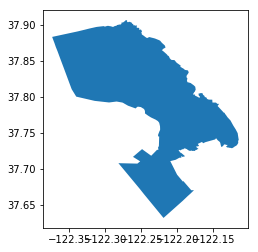

In [207]:
eastbay_cities.plot()

In [225]:
filepath = 'data/wc2.0_30s_tavg/wc2.0_30s_tavg_06.tif'

with rasterio.open('data/wc2.0_30s_tavg/wc2.0_30s_tavg_06.tif') as src:
    print(src.profile)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4e+38, 'width': 43200, 'height': 21600, 'count': 1, 'crs': CRS({'init': 'epsg:4326'}), 'transform': Affine(0.008333333333333333, 0.0, -180.0,
       0.0, -0.008333333333333333, 90.0), 'tiled': False, 'compress': 'deflate', 'interleave': 'band'}


In [158]:
with rasterio.open(filepath) as src:
    out_image, out_transform = rasterio.mask.mask(src, eastbay_cities.geometry,
                                                        crop=True)
    out_meta = src.meta.copy()

In [159]:
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
with rasterio.open("RGB.byte.masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)

In [162]:
with rasterio.open('RGB.byte.masked.tif') as src:
    wind_raster = src.read()

/anaconda3/envs/OSMNX/lib/python3.6/site-packages/matplotlib/image.py:429: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / 0.8)


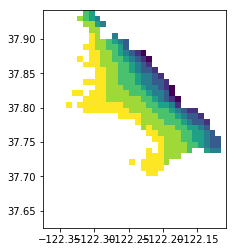

In [163]:
raster = rasterio.open('RGB.byte.masked.tif')
show(raster);

In [150]:
GSV_all = import_gpd('data/GSV_all_new.csv')

In [151]:
np.array(GSV_all['Longitude'].values)

array([-122.3225938, -122.32231  , -122.3223008, ..., -122.1389953,
       -122.1389192, -122.1388431])

In [165]:
from feature_geometries import *
import rasterio

lons = np.array(GSV_all['Longitude'].values)
lats = np.array(GSV_all['Latitude'].values)
winds = np.zeros(GSV_all.shape[0])

with rasterio.open(filepath) as src:
    for i, val in enumerate(src.sample(zip(lons, lats))):
        winds[i] = val

In [169]:
winds = np.where(winds < 0, np.nan, winds)

In [154]:
GSV_all['wind'] = winds

In [174]:
winds

array([17.5       , 17.5       , 17.5       , ..., 18.10000038,
       18.10000038, 18.10000038])

In [232]:
import rasterio
import numpy as np
from glob import glob
import os

data_dir = 'data/wc2.0_30s_tavg' # Or sys.argv[1]
file_list = glob(os.path.join(data_dir, '*.tif'))
file_list

['data/wc2.0_30s_tavg/wc2.0_30s_tavg_08.tif',
 'data/wc2.0_30s_tavg/wc2.0_30s_tavg_09.tif',
 'data/wc2.0_30s_tavg/wc2.0_30s_tavg_07.tif',
 'data/wc2.0_30s_tavg/wc2.0_30s_tavg_06.tif',
 'data/wc2.0_30s_tavg/wc2.0_30s_tavg_12.tif',
 'data/wc2.0_30s_tavg/wc2.0_30s_tavg_04.tif',
 'data/wc2.0_30s_tavg/wc2.0_30s_tavg_10.tif',
 'data/wc2.0_30s_tavg/wc2.0_30s_tavg_11.tif',
 'data/wc2.0_30s_tavg/wc2.0_30s_tavg_05.tif',
 'data/wc2.0_30s_tavg/wc2.0_30s_tavg_01.tif',
 'data/wc2.0_30s_tavg/wc2.0_30s_tavg_02.tif',
 'data/wc2.0_30s_tavg/wc2.0_30s_tavg_03.tif']

In [233]:
def read_file(file):
    with rasterio.open(file) as src:
        return(src.read(1))

# Read all data as a list of numpy arrays 
array_list = [read_file(x) for x in file_list]
# Perform averaging
array_out = np.mean(array_list, axis=0)
array_out

/anaconda3/envs/OSMNX/lib/python3.6/site-packages/numpy/core/_methods.py:75: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


array([[      -inf,       -inf,       -inf, ...,       -inf,       -inf,
              -inf],
       [      -inf,       -inf,       -inf, ...,       -inf,       -inf,
              -inf],
       [      -inf,       -inf,       -inf, ...,       -inf,       -inf,
              -inf],
       ...,
       [-33.833336, -44.44167 , -44.44167 , ..., -41.350002, -30.708334,
        -30.699999],
       [  0.      ,   0.      ,   0.      , ...,   0.      ,   0.      ,
          0.      ],
       [  0.      ,   0.      ,   0.      , ...,   0.      ,   0.      ,
          0.      ]], dtype=float32)

In [234]:
array_out.shape

(21600, 43200)

In [235]:
# Get metadata from one of the input files
with rasterio.open(file_list[0]) as src:
    meta = src.meta

meta.update(dtype=rasterio.float32)

# Write output file
with rasterio.open('data/wc2.0_30s_tavg/avg_tavg.tif', 'w', **meta) as dst:
    dst.write(array_out.astype(rasterio.float32), 1)

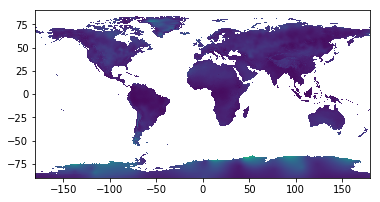

In [230]:
raster = rasterio.open('data/wc2.0_30s_wind/avg_wind.tif')
show(raster);

In [222]:
from feature_geometries import *
import rasterio

lons = np.array(GSV_all['Longitude'].values)
lats = np.array(GSV_all['Latitude'].values)
winds = np.zeros(GSV_all.shape[0])

with rasterio.open('data/wc2.0_30s_wind/avg_wind.tif') as src:
    for i, val in enumerate(src.sample(zip(lons, lats))):
        winds[i] = val
        
winds = np.where(winds < 0, np.nan, winds)

In [212]:
np.sum(np.isnan(winds))

16

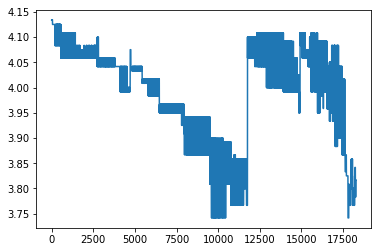

In [223]:
plt.plot(winds)